In [1]:
%cd ..

/home/ltorres/leo/Cloud-Classification/code


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

In [4]:
import os
from torchvision.io import read_image
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx

In [5]:
from src import config
from src import engine
from src import utils

In [7]:
from recipe.utils import *
from recipe.graph_modules import GraphClassifierF

In [8]:
import random
from random import sample
from sklearn.metrics import accuracy_score

In [9]:
torch.manual_seed(7)
np.random.seed(7)
random.seed(7)

---

In [10]:
def get_targets(paths):
        return list(map(int,list(map(int,[os.path.basename(x).split('_')[0] 
                                          for x in paths]))))

In [11]:
def sample_paths(df, n=2, col='target', random_state = 7):
    
    paths = list()
    
    for key, sub_df in df.groupby(col):
        paths+= sub_df.sample(n=n, random_state=random_state)['path'].tolist()
        
    return paths

---

# 1. Leer df train y funcion de sampleo por clase

In [12]:
paths = utils.get_gcd_paths('/data/ltorres','train')
targets = get_targets(paths)

In [13]:
df_train = pd.DataFrame({'path':paths, 'target':targets})

# 2. Inferencia en batch de test con distintos pivots

## 2.1 test_loader

In [14]:
path_test_images = utils.get_gcd_paths('/data/ltorres','test')

test_dataset = GCD(path_test_images, resize=256)

test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=1,
        num_workers=4,
        shuffle=False,
    )

In [15]:
len(test_dataset)

9000

## 2.2 Construir grafo con imagenes pivot

In [49]:
model_path = '/data/ltorres/CLOUD_CLASSIFICATION_WEIGHTS/wandb_1353k0xc_model.pt'

In [51]:
model.load_state_dict(torch.load(model_path, map_location = 'cuda'))

<All keys matched successfully>

In [50]:
device='cuda'

model = GraphClassifierF(
                 hidden_dim = 512, 
                 num_hidden = 2, 
                 num_classes = 7,
                 feature_extraction = False,
                 conv_type = 'gcn',
                 conv_parameters = {"num_heads":2, "agg":"sum"},
                 gnn_dropout = 0.3,
                 adjacency_builder = 'pearson_corr',
                 builder_parameter = 0.7,
                 use_both_heads = False,
                ).to(device)

model.load_state_dict(torch.load(model_path, map_location = 'cuda'))

model.eval();

In [23]:
def get_pivot_deep_features(train_paths, model, device):
    
    ## 1. train data loader
    pivot_dataset = GCD(train_paths, resize=256)
    pivot_loader = torch.utils.data.DataLoader(
            pivot_dataset,
            batch_size=32,
            num_workers=8,
            shuffle=False,
        )
    
    
    ## 2. Append deep features
    pivot_features = list()
        
    for data in pivot_loader:
        with torch.no_grad():
            deep_features = model.get_deep_features(data['images'].to(device)).cpu()
            pivot_features.append(deep_features)
        
    return torch.cat(pivot_features, dim=0)

In [24]:
pivot_paths = sample_paths(df_train, n=2)

In [26]:
pivot_features = get_pivot_deep_features(pivot_paths, model, device)

In [27]:
pivot_features.shape

torch.Size([14, 2048])

## evaluacion

In [48]:
df_results = pd.DataFrame()

for N in [4]:
    print(f'######## STARTING N = {N} ########')
    print('1. Reading pivot paths')
    pivot_paths = sample_paths(df_train, n=N, random_state=11)

    # pivot_paths = [
    #     'D:\\Tesis\\REPO\\GCD/train/1_cumulus/1_cumulus_000082.jpg',
    #     'D:\\Tesis\\REPO\\GCD/train/1_cumulus/1_cumulus_000127.jpg',
    #     'D:\\Tesis\\REPO\\GCD/train/2_altocumulus/2_altocumulus_000003.jpg',
    #     'D:\\Tesis\\REPO\\GCD/train/2_altocumulus/2_altocumulus_000028.jpg',
    #     'D:\\Tesis\\REPO\\GCD/train/3_cirrus/3_cirrus_000035.jpg',
    #     'D:\\Tesis\\REPO\\GCD/train/3_cirrus/3_cirrus_000115.jpg',
    #     'D:\\Tesis\\REPO\\GCD/train/4_clearsky/4_clearsky_000004.jpg',
    #     'D:\\Tesis\\REPO\\GCD/train/4_clearsky/4_clearsky_000055.jpg',
    #     'D:\\Tesis\\REPO\\GCD/train/5_stratocumulus/5_stratocumulus_000003.jpg',
    #     'D:\\Tesis\\REPO\\GCD/train/5_stratocumulus/5_stratocumulus_000069.jpg',
    #     'D:\\Tesis\\REPO\\GCD/train/6_cumulonimbus/6_cumulonimbus_000011.jpg',
    #     'D:\\Tesis\\REPO\\GCD/train/6_cumulonimbus/6_cumulonimbus_000059.jpg',
    #     'D:\\Tesis\\REPO\\GCD/train/7_mixed/7_mixed_000006.jpg',
    #     'D:\\Tesis\\REPO\\GCD/train/7_mixed/7_mixed_000039.jpg',
    # ]



    print('2. Calculating pivot deep features')
    #pivot_features = get_pivot_deep_features(pivot_paths, model, device)
    pivot_features=torch.load("pivot_nodes/centroid_sample.pt")
    print(f'{pivot_features.shape[0]} PIVOT IMAGES')
    
    
    test_targets = list()
    test_predictions = list()

    print('3. Calculating predictions')
    for data in tqdm(test_loader):
        pred_img = data['images']

        pred_feature = model.get_deep_features(pred_img.to(device)).cpu()

        pred_images = torch.cat([pivot_features, pred_feature], dim=0).to(device)

        with torch.no_grad():
            preds = torch.argmax(F.softmax(model.predict(pred_images).cpu(),dim=1), dim=1)


            test_predictions.append(preds[-1].item())
            test_targets.append(data['targets'].item())
    
    acc = accuracy_score(test_targets, test_predictions)
    
    print(f"N={N}: Test Accuracy: {acc}")
    
    df_results[f'predictions_{N}'] = test_predictions
    df_results[f'targets_{N}'] = test_targets

######## STARTING N = 4 ########
1. Reading pivot paths
2. Calculating pivot deep features
28 PIVOT IMAGES
3. Calculating predictions


100%|██████████| 9000/9000 [01:14<00:00, 121.42it/s]


N=4: Test Accuracy: 0.7276666666666667


In [30]:
df_results.to_csv('inference experiments/df_results_s11.csv', index=False)

In [31]:
from sklearn.metrics import accuracy_score

In [32]:
accuracy_score(test_targets, test_predictions)

0.7232222222222222

In [33]:
r = np.array(test_targets)[(np.array(test_targets) == np.array(test_predictions))]

In [34]:
pd.Series(r).value_counts()/pd.Series(np.array(test_targets)).value_counts()

0    0.646667
1    0.461333
2    0.845950
3    0.964128
4    0.496648
5    0.893155
6    0.253707
dtype: float64

---

# Curva de accuracy por numero de imagenes pivot por clase

In [35]:
%ls

'data preprocessing'/      inferencia_top_k_similar.csv   src/
 images/                   notebooks/                     ViG/
'inference experiments'/   recipe/                        wandb/


In [36]:
df_result = pd.read_csv('inference experiments/df_results_s11.csv')

In [37]:
accuracy_score

<function sklearn.metrics._classification.accuracy_score(y_true, y_pred, *, normalize=True, sample_weight=None)>

In [38]:
results = dict()

for N in [2,4,8,10,15,20,40,50,100]:
    
    results[N] = accuracy_score(df_result[f"targets_{N}"], df_result[f"predictions_{N}"])
    
results_data = pd.Series(results)*100

KeyError: 'targets_2'

In [ ]:
plt.figure(figsize=(11,5))
results_data.plot.line()
plt.xticks(results_data.index.values)
plt.title('Accuracy by # of pivot images per class')
plt.ylabel('Accuracy (%)')
plt.xlabel('# pivot images per class')
plt.show()

---

In [ ]:
def get_targets_wname(paths):
        return list(map(str,list(map(str,["_".join(os.path.basename(x).split('_')[:-1]) 
                                          for x in paths]))))

In [ ]:
pivot_paths = sample_paths(df_train, n=4, random_state=10)
pivot_targets = get_targets_wname(pivot_paths)

#### read pivot images

In [39]:
images = []

for p in pivot_paths:
    img = read_image(p).int().numpy().transpose(1,2,0)
    images.append(img)

NameError: name 'pivot_targets' is not defined

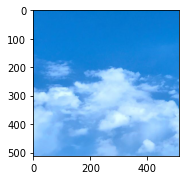

In [40]:
fig = plt.figure(figsize=(12, 28))
columns = 4
rows = 8
for i in range(1, 4*7 +1):
    img = images[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.title(f'label: {pivot_targets[i-1]}')
plt.savefig('inference experiments/best_pivot_images.png')
plt.show()